In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score,classification_report, confusion_matrix, RocCurveDisplay,ConfusionMatrixDisplay 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv("data.csv",index_col=0)

In [5]:
df.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


In [6]:
X = df.drop(columns="result", inplace=False)
y = df["result"]
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, random_state=1,shuffle=True)

In [7]:
print(f"shape of X: {X.shape}")
print(f"shape of y: {y.shape}")
print(f"shape of X_train: {X_train.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_test: {y_test.shape}")


shape of X: (863, 13)
shape of y: (863,)
shape of X_train: (647, 13)
shape of y_train: (647,)
shape of X_test: (216, 13)
shape of y_test: (216,)


In [8]:
X.head()

,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos
0,104,8,1,66.0,1,0,14,31,19,12,3,1,8
1,101,8,0,56.0,0,1,14,31,19,12,3,1,0
2,137,8,1,46.0,0,1,14,31,19,12,3,1,13
3,116,8,0,60.0,1,0,14,31,19,12,3,1,0
4,116,8,1,58.0,0,0,14,31,19,12,3,1,0


In [9]:
y.head()


0    1
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [10]:
final_precision = dict()
final_recall = dict()
final_f1_score = dict()
final_roc_auc = dict()
# To hold all preditions of all models
y_predictions = dict()
plot_all_roc = dict()



## K Fold 

In [11]:
N_FOLDS = 5

In [12]:
# Plot ROC curve
def plot_ROC(fpr,tpr,ROC, x):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {ROC:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{x} (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## KNN

In [13]:
neighbors = [3, 5, 7, 9, 11, 21, 31, 41]
weights = ["uniform", 'distance']
params = {"n_neighbors": neighbors, "weights":weights}

KNN = KNeighborsClassifier()
gs_KNN = GridSearchCV(KNN,param_grid=params,cv=N_FOLDS, scoring="f1")
gs_KNN.fit(X=X_train,y=y_train)
best_model = gs_KNN.best_estimator_

y_pred_KNN = best_model.predict(X_test)
y_predictions["KNN"] = y_pred_KNN

print(f"Optimal hyperparameters:{gs_KNN.best_params_}")
print(f"KNN F1_score:{gs_KNN.best_score_}")


Optimal hyperparameters:{'n_neighbors': 5, 'weights': 'distance'}
KNN F1_score:0.7326730962771008


In [14]:
final_precision["KNN"] = precision_score(y_test,y_pred_KNN)
final_recall["KNN"] = recall_score(y_test,y_pred_KNN)
final_f1_score["KNN"] = f1_score(y_test,y_pred_KNN)

print(f"precision:\n{precision_score(y_test,y_pred_KNN):0.2f}")
print(f"\nrecall:\n{recall_score(y_test,y_pred_KNN):0.2f}")
print(f"\nf1_score:\n{f1_score(y_test,y_pred_KNN):0.2f}")

precision:
0.80

recall:
0.67

f1_score:
0.73


In [15]:
print(classification_report(y_true=y_test,y_pred=y_pred_KNN))


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       186
           1       0.80      0.67      0.73        30

    accuracy                           0.93       216
   macro avg       0.87      0.82      0.84       216
weighted avg       0.93      0.93      0.93       216




roc_auc:
0.93


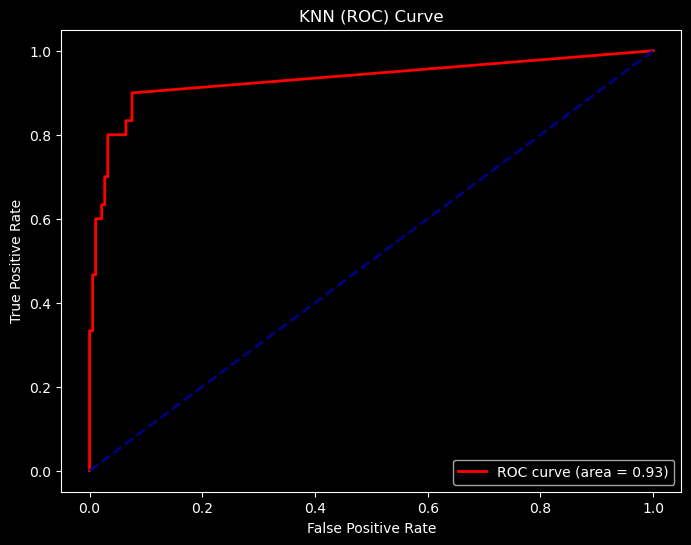

In [16]:
# ROC curve
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
final_roc_auc["KNN"] = roc_auc
plot_all_roc["KNN"] = [fpr,tpr,roc_auc]
print(f"\nroc_auc:\n{roc_auc:0.2f}")
plot_ROC(fpr,tpr,roc_auc,"KNN")

#### Best value of K is 5 and weights: distance according to the GridSearchCV function so I used it for further comparison against other data.

## Logistic regression

In [17]:
# Model have a converganse problem so I will scale the data and use max_iter variable
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
}
Logistic_reg_model = LogisticRegression(random_state=1,max_iter=2000)
log_cv = GridSearchCV(Logistic_reg_model, param_grid=params, cv=N_FOLDS, scoring="f1")
log_cv.fit(X=X_train_scaled, y=y_train)
best_model_log = log_cv.best_estimator_
y_pred_log_reg = best_model_log.predict(X_test_scaled)
print(f"Optimal hyperparameters:{log_cv.best_params_}")
print(f"Logistic Regression F1_score:{log_cv.best_score_}")

Optimal hyperparameters:{'C': 100, 'penalty': 'l2'}
Logistic Regression F1_score:0.8185188024041654


In [18]:
final_precision["Logistic_reg_model"] = precision_score(y_test,y_pred_log_reg)
final_recall["Logistic_reg_model"] = recall_score(y_test,y_pred_log_reg)
final_f1_score["Logistic_reg_model"] = f1_score(y_test,y_pred_log_reg)
y_predictions["Logistic_reg_model"] = y_pred_log_reg

y_roc = best_model_log.predict_proba(X_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_roc)
final_roc_auc["Logistic_reg_model"] = auc(fpr, tpr)
plot_all_roc["Logistic Regression"] = [fpr,tpr,auc(fpr, tpr)]

print(f"precision:\n{precision_score(y_test,y_pred_log_reg):0.2f}")
print(f"\nrecall:\n{recall_score(y_test,y_pred_log_reg):0.2f}")
print(f"\nf1_score:\n{f1_score(y_test,y_pred_log_reg):0.2f}")
print(f"\nroc_auc:\n{final_roc_auc['Logistic_reg_model']:0.2f}")

precision:
0.88

recall:
0.47

f1_score:
0.61

roc_auc:
0.91


In [19]:
print(classification_report(y_true=y_test,y_pred=y_pred_log_reg))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95       186
           1       0.88      0.47      0.61        30

    accuracy                           0.92       216
   macro avg       0.90      0.73      0.78       216
weighted avg       0.91      0.92      0.91       216



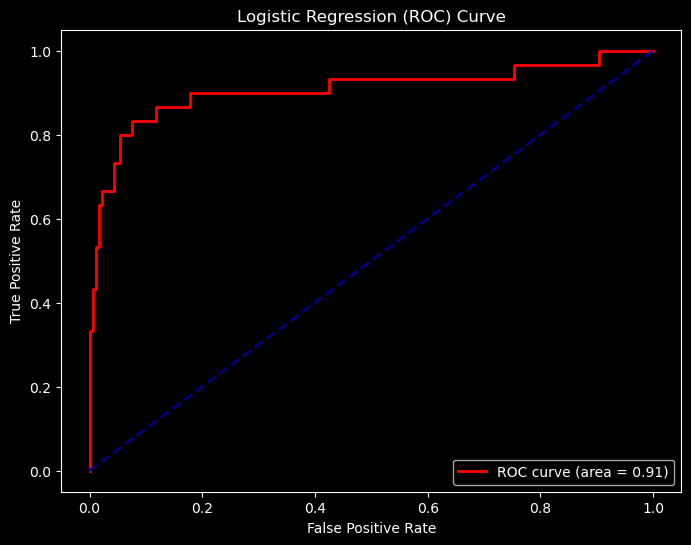

In [20]:
# Plot ROC curve
plot_ROC(fpr,tpr,final_roc_auc["Logistic_reg_model"],"Logistic Regression")

#### Optimal hyperparameters:{'C': 100, 'penalty': 'l2'}

## Gaussian Bayes Classifier 

In [21]:
gnb = GaussianNB()

gnb.fit(X=X_train, y=y_train)
y_pred_gnb = gnb.predict(X_test)
final_precision["gnb"] = precision_score(y_test,y_pred_gnb)
final_recall["gnb"] = recall_score(y_test,y_pred_gnb)
final_f1_score["gnb"] = f1_score(y_test,y_pred_gnb)
y_predictions["gnb"] = y_pred_gnb


In [22]:
y_roc = gnb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_roc)
final_roc_auc["gnb"] = auc(fpr, tpr)
plot_all_roc["gnb"] = [fpr,tpr,auc(fpr, tpr)]

print(f"precision:\n{final_precision['gnb']:0.2f}")
print(f"\nrecall:\n{final_recall['gnb']:0.2f}")
print(f"\nf1_score:\n{final_f1_score['gnb']:0.2f}")
print(f"\nroc_auc:\n{final_roc_auc['gnb']:0.2f}")

precision:
0.38

recall:
0.80

f1_score:
0.51

roc_auc:
0.83


In [23]:
print(classification_report(y_true=y_test,y_pred=y_pred_gnb))


              precision    recall  f1-score   support

           0       0.96      0.78      0.86       186
           1       0.38      0.80      0.51        30

    accuracy                           0.79       216
   macro avg       0.67      0.79      0.69       216
weighted avg       0.88      0.79      0.81       216



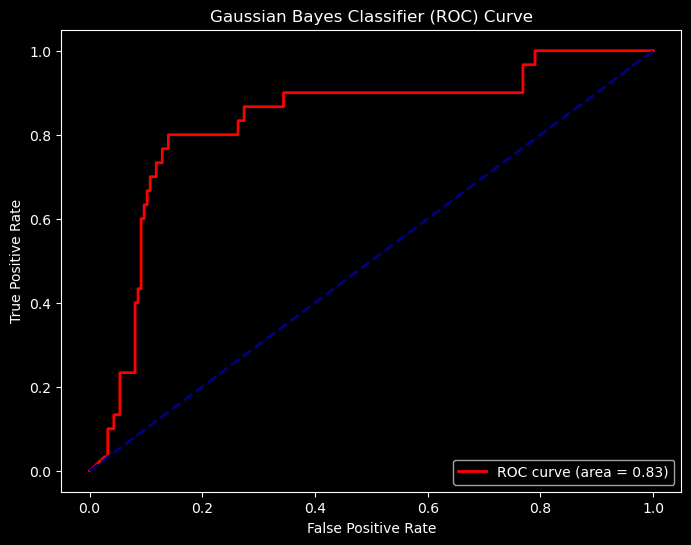

In [24]:
# Plot ROC curve
plot_ROC(fpr,tpr,final_roc_auc["gnb"],"Gaussian Bayes Classifier")

In [25]:
final_roc_auc

{'KNN': 0.9309139784946235,
 'Logistic_reg_model': 0.9078853046594982,
 'gnb': 0.8289426523297492}

## Checking the confusion matrix of these outputs

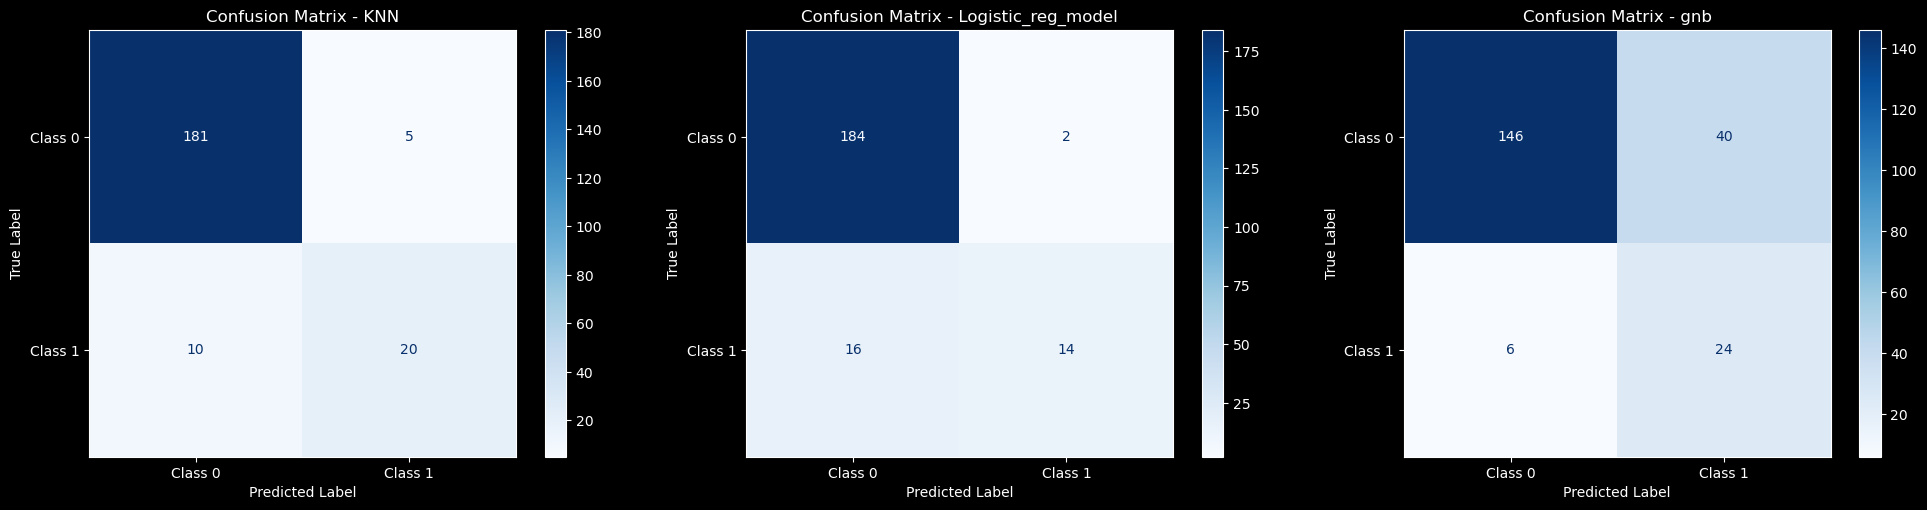

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for (model_name, predicted_labels), ax in zip(y_predictions.items(), axes.flatten()):
    cm = confusion_matrix(y_test, predicted_labels)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']).plot(cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout()
plt.show()


## Choosing the best model

**Precision**: is that your model predicts more correctly but may miss some correct cases, so the more accurate the ones you say are correct are actually correct will give higher precision.<br>
**Recall**: is getting all the correct data even if some of them mayn't be correct as long as you find more correct it will give higher recall.

I will assume that the +ve class here is death(not recovered).
- So if want to focus on minimizing deaths and treating any one which may be suspect to death we use highest Recall(<b>capturing all positive cases</b>).<br>
- If this treatment is harmfull or not avaliable in huge quntity then we want to make sure that all who we predict will not recover will actually not recover although we may miss predict some casses as recovered but they wont recover then we will use highest Precision(<b>minimizing false positives</b>).

A good approach in an inbalanced datasheet is to use **F-1 score** as it takes into consideration precision and recall, or using **AUC of ROC curve**.



#### First I Will get the best model according to AUC of ROC curve

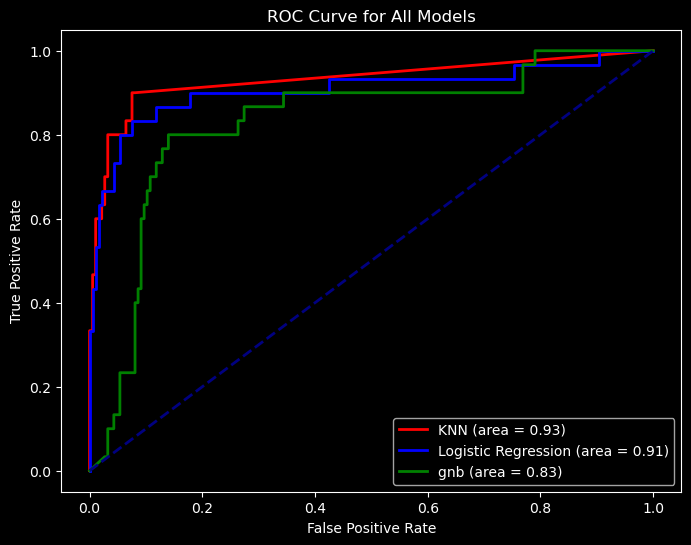

In [27]:
# Plotting ROC of all models
def plot_ROC_all(fpr, tpr, ROC, x, color):
    plt.plot(fpr, tpr, lw=2, label=f'{x} (area = {ROC:.2f})', color=color)

plt.figure(figsize=(8, 6))

# color for each model
colors = ['red', 'blue', 'green']  

for i, (name, roc) in enumerate(plot_all_roc.items()):
    plot_ROC_all(roc[0], roc[1], roc[2], f"{name}", color=colors[i])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for All Models')
plt.legend(loc='lower right')
plt.show()


#### According to the AUC of ROC **KNN** is the best model


#### F-1 score

In [28]:
max_key = max(final_f1_score, key=lambda k: final_f1_score[k])
max_value = max(final_f1_score.values())
print(f"The model with the highest F1 score is: {max_key}\n and its value in precentage is {max_value*100:0.2f}%")


The model with the highest F1 score is: KNN
 and its value in precentage is 72.73%


#### According to the f1 score the best model is **KNN**

#### Data Summary

In [29]:
# To make a data summary
# KNN
summary_df = pd.DataFrame([{
    'Model': 'KNN',
    'Best Parameters': gs_KNN.best_params_,
    'ROC_AUC': f'{final_roc_auc["KNN"]:0.2f}',
    'F1_score': f'{final_f1_score["KNN"]:0.2f}',
    'Precision': f'{final_precision["KNN"]:0.2f}',
    'Recall': f'{final_recall["KNN"]:0.2f}'
}])
# Logistic Regression
summary_df = pd.concat([summary_df, pd.DataFrame([{
    'Model': 'Logistic Regeression',
    'Best Parameters': log_cv.best_params_,
    'ROC_AUC': f'{final_roc_auc["Logistic_reg_model"]:0.2f}',
    'F1_score': f'{final_f1_score["Logistic_reg_model"]:0.2f}',
    'Precision': f'{final_precision["Logistic_reg_model"]:0.2f}',
    'Recall': f'{final_recall["Logistic_reg_model"]:0.2f}'
}])], ignore_index=True)
# Gaussian Bayes Classifier
summary_df = pd.concat([summary_df, pd.DataFrame([{
    'Model': 'Gaussian Bayes Classifier',
    'Best Parameters': 'No Parameters',
    'ROC_AUC': f'{final_roc_auc["gnb"]:0.2f}',
    'F1_score': f'{final_f1_score["gnb"]:0.2f}',
    'Precision': f'{final_precision["gnb"]:0.2f}',
    'Recall': f'{final_recall["gnb"]:0.2f}'
}])], ignore_index=True)

summary_df

,Model,Best Parameters,ROC_AUC,F1_score,Precision,Recall
0,KNN,"{'n_neighbors': 5, 'weights': 'distance'}",0.93,0.73,0.80,0.67
1,Logistic Regeression,"{'C': 100, 'penalty': 'l2'}",0.91,0.61,0.88,0.47
2,Gaussian Bayes Classifier,No Parameters,0.83,0.51,0.38,0.80


## The best Model for this specific task is **KNN**

In [31]:
import joblib

# Assuming model1, model2, and model3 are your trained models
joblib.dump(gs_KNN.best_estimator_, 'KNN.pkl')
joblib.dump(best_model_log, 'Logistic regression.pkl')
joblib.dump(gnb, 'gnb.pkl')


['gnb.pkl']